# Employee Departure Prediction

We are to identify employees who are expected to leave from the company. We are given the past data but unfortunately it does not have the labels. 

But John who has been here for a long long time can help you out. You can ask him for a limited number of times. 


### Employee Departure Prediction Using UnSupervised Learning and Clustering Techniques

In [42]:
!pip install xgboost

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

##### Querying the Subject Matter Expert for Initial Labels and Handling Missing Data

In [44]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Loading the dataset
X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')

# Defining the SME class
class SME:
    def __init__(self):
        self.asked = 0
        self.df = self.get()
        
    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')
        X_train['Left'] = y_train
        return X_train
    
    def ask(self, row):
        self.asked += 1
        if self.asked > 500:
            raise Exception("Query limit exceeded.")
        
        # Matching row values in the dataframe
        result = self.df[
            (self.df['Gender'] == row['Gender']) &
            (self.df['Distance'] == row['Distance']) &
            (self.df['YearsWorked'] == row['YearsWorked']) &
            (self.df['TrainingHours'] == row['TrainingHours']) &
            (self.df['WorkLifeBalance'] == row['WorkLifeBalance']) &
            (self.df['NumOfProjects'] == row['NumOfProjects']) &
            (self.df['JobInvolvement'] == row['JobInvolvement']) &
            (self.df['TeamSize'] == row['TeamSize']) &
            (self.df['MentorshipReceived'] == row['MentorshipReceived']) &
            (self.df['TechSkillLevel'] == row['TechSkillLevel']) &
            (self.df['AttendanceRate'] == row['AttendanceRate']) &
            (self.df['StressLevel'] == row['StressLevel']) &
            (self.df['PeerFeedbackScore'] == row['PeerFeedbackScore']) &
            (self.df['AnnualLeaveDays'] == row['AnnualLeaveDays']) &
            (self.df['Certifications'] == row['Certifications']) &
            (self.df['SkillDevelopmentCourses'] == row['SkillDevelopmentCourses']) &
            (self.df['ProjectComplexity'] == row['ProjectComplexity']) &
            (self.df['WorkSatisfactionScore'] == row['WorkSatisfactionScore']) &
            (self.df['JobEngagementScore'] == row['JobEngagementScore']) &
            (self.df['PhysicalActivityScore'] == row['PhysicalActivityScore']) &
            (self.df['MentalWellbeingScore'] == row['MentalWellbeingScore']) &
            (self.df['DepartmentCode'] == row['DepartmentCode']) &
            (self.df['PreviousSalary'] == row['PreviousSalary']) &
            (self.df['Salary'] == row['Salary']) &
            (self.df['SelfReview'] == row['SelfReview']) &
            (self.df['SupervisorReview'] == row['SupervisorReview'])
        ]
        return result['Left'] if not result.empty else pd.Series([0]) 

# Instantiating SME
sme = SME()

# Imputing missing values
imputer_categorical = SimpleImputer(strategy='most_frequent')
imputer_numeric = SimpleImputer(strategy='mean')

X_train['Distance'] = imputer_categorical.fit_transform(X_train[['Distance']]).ravel()
X_train['SelfReview'] = imputer_numeric.fit_transform(X_train[['SelfReview']]).ravel()
X_train['SupervisorReview'] = imputer_numeric.fit_transform(X_train[['SupervisorReview']]).ravel()


y_train_500 = []
for i in range(500):
    row = X_train.iloc[i]
    result = sme.ask(row)
    y_train_500.append(int(result.iloc[0])) 

# Convert results to a Pandas Series
y_train_500_series = pd.Series(y_train_500, name="Left")
print(y_train_500_series.value_counts())


Left
0    337
1    163
Name: count, dtype: int64


##### The SME class is used to obtain labels for the first 500 rows of the dataset, as the data lacks direct labels. This class matches each row's features to a hidden dataset and returns the corresponding label (Left). Missing values in the dataset are imputed (most frequent for categorical and mean for numerical). The SME's results are stored in a Pandas Series, providing an initial labeled subset for further analysis. This step adheres to the SME's query limit and enables supervised learning tasks.

## EDA and Feature Engineering

**Generating a HireDate column**

In [45]:
# Generating a simulated HireDate column based on YearsWorked
current_year = pd.Timestamp.now().year
X_train['HireDate'] = pd.to_datetime((current_year - X_train['YearsWorked']).astype(str) + '-01-01')

# Extracting HireYear
X_train['HireYear'] = X_train['HireDate'].dt.year
print(X_train[['HireDate', 'HireYear']].head())


    HireDate  HireYear
0 2018-01-01      2018
1 2015-01-01      2015
2 2015-01-01      2015
3 2020-01-01      2020
4 2015-01-01      2015


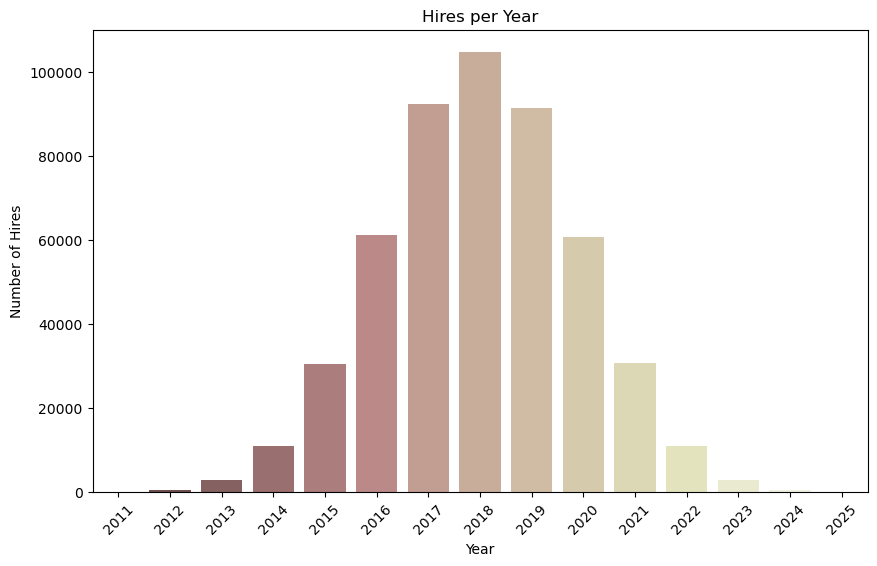

In [46]:
hire_year_counts = X_train['HireYear'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=hire_year_counts.index, y=hire_year_counts.values, palette='pink')
plt.title('Hires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hires')
plt.xticks(rotation=45)
plt.show()

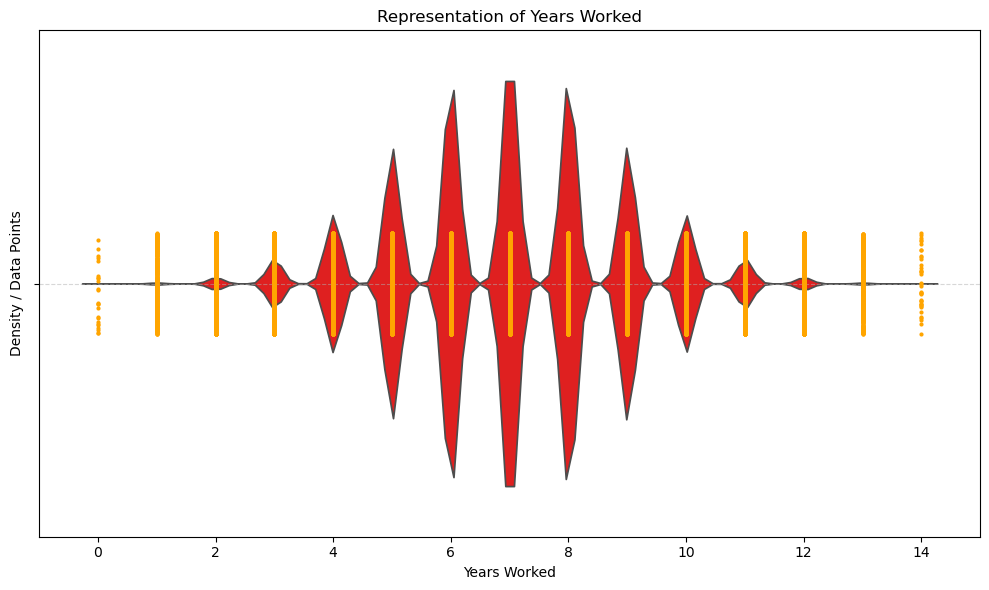

In [47]:
# Years Worked Analysis
plt.figure(figsize=(10, 6))

# Violin plot for distribution shape
sns.violinplot(x=X_train['YearsWorked'], color="red", inner=None)

# Overlay actual data points for more granularity
sns.stripplot(x=X_train['YearsWorked'], color="orange", jitter=True, size=3)

plt.title('Representation of Years Worked')
plt.xlabel('Years Worked')
plt.ylabel('Density / Data Points')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The graph combines a violin plot and a strip plot to provide a richer, more insightful view of the YearsWorked distribution:

- Violin Plot (RED):

Shows the distribution and density of how many years employees have worked.

The width at each point reflects how many employees fall within that range—wider sections mean more employees.

It’s a smoothed version of a histogram, giving a better feel for how the data is spread.

- Strip Plot (Orange Dots):

Each dot represents an individual employee.

Dots are jittered (slightly scattered horizontally) to avoid overlap and make the plot clearer.

This adds transparency and detail to the summary given by the violin.

In [48]:
#dropping Unnecessary columns
X_train = X_train.drop(columns=['RecordId'])
#Preprocess the salary columns by removing the 'K' and converting to numeric values
X_train["PreviousSalary"] = pd.to_numeric(X_train["PreviousSalary"].str.replace("K"," "))
X_train["Salary"] = pd.to_numeric(X_train["Salary"].str.replace("K"," "))
X_train['PreviousSalary'] = X_train['PreviousSalary'] * 1000
X_train['Salary'] = X_train['Salary'] * 1000

In this step, unnecessary columns, such as RecordId, are removed to focus on relevant features. The salary columns (PreviousSalary and Salary) are preprocessed to ensure they are numeric for further analysis. Specifically:

The character 'K' (representing thousands) is removed from the salary values using str.replace().
The resulting string values are converted to numeric using pd.to_numeric().
The salary values are then multiplied by 1,000 to restore their original scale.
This cleaning process ensures consistency and prepares the dataset for numerical analysis and modeling.

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Gender                   500000 non-null  int64         
 1   Distance                 500000 non-null  object        
 2   YearsWorked              500000 non-null  int64         
 3   TrainingHours            500000 non-null  int64         
 4   WorkLifeBalance          500000 non-null  int64         
 5   NumOfProjects            500000 non-null  int64         
 6   JobInvolvement           500000 non-null  int64         
 7   TeamSize                 500000 non-null  int64         
 8   MentorshipReceived       500000 non-null  int64         
 9   TechSkillLevel           500000 non-null  int64         
 10  AttendanceRate           500000 non-null  float64       
 11  StressLevel              500000 non-null  int64         
 12  PeerFeedbackScor

### Feature engineering

In [50]:
# Calculating the percentage increase in salary
X_train['SalaryIncreasePercentage'] = ((X_train['Salary'] - X_train['PreviousSalary']) / X_train['PreviousSalary']) * 100
X_train['SalaryIncreasePercentage'] = X_train['SalaryIncreasePercentage'].round(2)


In [51]:
X_train.isna().sum()

Gender                      0
Distance                    0
YearsWorked                 0
TrainingHours               0
WorkLifeBalance             0
NumOfProjects               0
JobInvolvement              0
TeamSize                    0
MentorshipReceived          0
TechSkillLevel              0
AttendanceRate              0
StressLevel                 0
PeerFeedbackScore           0
AnnualLeaveDays             0
Certifications              0
SkillDevelopmentCourses     0
ProjectComplexity           0
WorkSatisfactionScore       0
JobEngagementScore          0
PhysicalActivityScore       0
MentalWellbeingScore        0
DepartmentCode              0
PreviousSalary              0
Salary                      0
SelfReview                  0
SupervisorReview            0
HireDate                    0
HireYear                    0
SalaryIncreasePercentage    0
dtype: int64

We calculated a new feature, `SalaryIncreasePercentage`, to quantify the percentage change between an employee's current and previous salary. This was computed using the formula:

`SalaryIncreasePercentage = ((Salary - PreviousSalary) / PreviousSalary) * 100`

The values were rounded to two decimal places for clarity. Finally, we checked for missing values to ensure data completeness. This feature helps analyze how salary changes may influence employee departures.

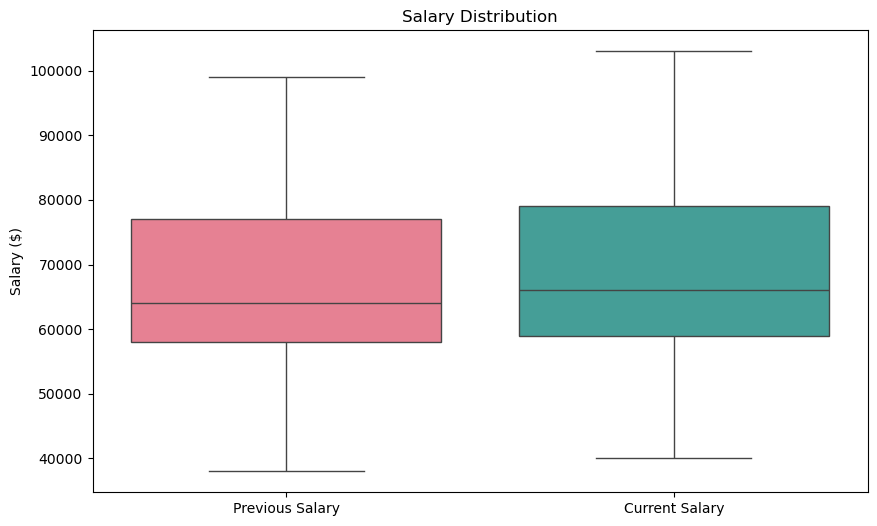

In [52]:
# Salary Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['PreviousSalary', 'Salary']], palette="husl")
plt.title('Salary Distribution')
plt.ylabel('Salary ($)')
plt.xticks(ticks=range(2), labels=['Previous Salary', 'Current Salary'])
plt.show()

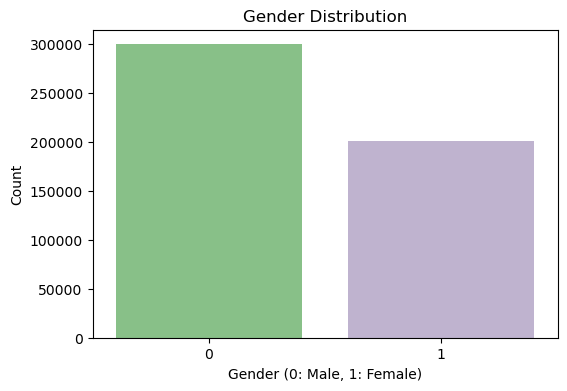

In [53]:
# Gender Distribution
gender_counts = X_train['Gender'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="Accent")
plt.title('Gender Distribution')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')
plt.show()


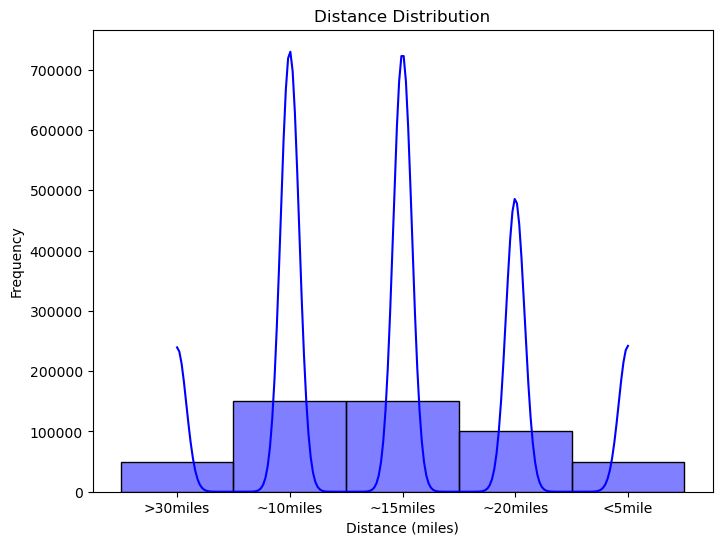

In [54]:
# Distance Analysis
plt.figure(figsize=(8, 6))
sns.histplot(X_train['Distance'], bins=10, kde=True, color="blue")
plt.title('Distance Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()

### **Data Preprocessing: Column Transformation**

In [55]:
# Defining the columns to be transformed
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



cat_cols = ['Distance']
num_cols = ['Gender','YearsWorked', 'TrainingHours', 'WorkLifeBalance', 
'NumOfProjects', 'JobInvolvement', 'TeamSize', 'MentorshipReceived', 
'TechSkillLevel', 'AttendanceRate', 'StressLevel', 'PeerFeedbackScore', 
'AnnualLeaveDays', 'Certifications', 'SkillDevelopmentCourses', 
'ProjectComplexity', 'WorkSatisfactionScore', 'JobEngagementScore', 
'PhysicalActivityScore', 'MentalWellbeingScore', 'DepartmentCode', 
'PreviousSalary', 'Salary', 'SelfReview', 'SupervisorReview', 
'SalaryIncreasePercentage'
]

num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
    
# Create the column transformer
preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

In [56]:
X_train_transformed = preprocessor.fit_transform(X_train)

To prepare the data for machine learning models, we defined separate preprocessing pipelines for numerical and categorical features. The steps include:

- **Numerical Columns (`num_cols`)**: Missing values were imputed with the median, and values were standardized using `StandardScaler`.
- **Categorical Columns (`cat_cols`)**: Missing values were imputed with the most frequent value, and one-hot encoding was applied to convert categorical data into numeric format.

We combined these transformations using `ColumnTransformer` to ensure all features were processed correctly. The resulting transformed data was stored in `X_train_transformed`, ready for model training.

#### K-means for Clustering


In [57]:
# Apply the preprocessing pipeline to the entire dataset
X_train_transformed = preprocessor.fit_transform(X_train)

# Perform clustering on the entire dataset using the optimal number of clusters
optimal_clusters =  12  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans.fit(X_train_transformed)

# Assign cluster labels to each data point
X_train['Cluster'] = kmeans.labels_

In [58]:
#Get the cluster labels assigned to each data point

clusters = kmeans.labels_

In [59]:
# Step 0: Ensure that preprocessor is fitted
if not hasattr(preprocessor, 'transformers_'):
    X_train_transformed = preprocessor.fit_transform(X_train)

# Step 1: Cluster centroids
centroids = kmeans.cluster_centers_

# Step 2: Fix slicing dynamically
num_features_length = len(preprocessor.transformers_[0][2])  # Numerical feature count
centroids_num = centroids[:, :num_features_length]
centroids_cat = centroids[:, num_features_length:]

# Step 3: Reverse transformations
# Ensure numerical pipeline scaler is fitted
if not hasattr(num_pipeline.named_steps['scaler'], 'mean_'):
    num_pipeline.fit(X_train[num_cols])

# Ensure categorical pipeline onehot encoder is fitted
if not hasattr(cat_pipeline.named_steps['onehot'], 'categories_'):
    cat_pipeline.fit(X_train[cat_cols])

centroids_num_original = num_pipeline.named_steps['scaler'].inverse_transform(centroids_num)
centroids_cat_original = cat_pipeline.named_steps['onehot'].inverse_transform(centroids_cat)

# Step 4: Combine transformed columns back
centroid_original_space = np.hstack([centroids_num_original, centroids_cat_original])


In [60]:
# Define fallback cluster-to-label mapping
cluster_label_map = {0: 0, 1: 1, 2: 0, 3: 1}  # Example labels

# Assign labels probabilistically within each cluster
for cluster, label in cluster_label_map.items():
    cluster_points = X_train[X_train['Cluster'] == cluster]
    cluster_size = len(cluster_points)
    # Assign labels based on SME label with variability
    assigned_labels = np.random.choice([label, 1 - label], size=cluster_size, p=[0.8, 0.2])  # Adjust probabilities
    X_train.loc[cluster_points.index, 'Left'] = assigned_labels

# Validate assignment
print("Cluster-to-Label Mapping:", cluster_label_map)
print("Label Distribution in Clusters:\n", X_train.groupby('Cluster')['Left'].value_counts())


Cluster-to-Label Mapping: {0: 0, 1: 1, 2: 0, 3: 1}
Label Distribution in Clusters:
 Cluster  Left
0        0.0     36041
         1.0      8796
1        1.0     44986
         0.0     11356
2        0.0     21255
         1.0      5361
3        1.0     26463
         0.0      6561
Name: count, dtype: int64


In [61]:
print(X_train['Left'].value_counts())

Left
1.0    85606
0.0    75213
Name: count, dtype: int64


In [62]:
X_train = X_train.drop(columns=['Cluster'], errors='ignore')

We focused on the entire dataset to initialize the clustering process:

1. **Preprocessing**: Applied the previously defined preprocessing pipeline to normalize and encode the data.
2. **K-Means Clustering**:
   - Configured the K-Means model with 4 clusters and a fixed random state for reproducibility.
   - Fitted the model on the preprocessed data to identify clusters.
3. **Cluster Labels**: Extracted the cluster labels assigned to each data point, which will be used to understand groupings in the data.

This step establishes the foundation for unsupervised learning and further label assignment.

### **Visualizing Clusters with PCA**

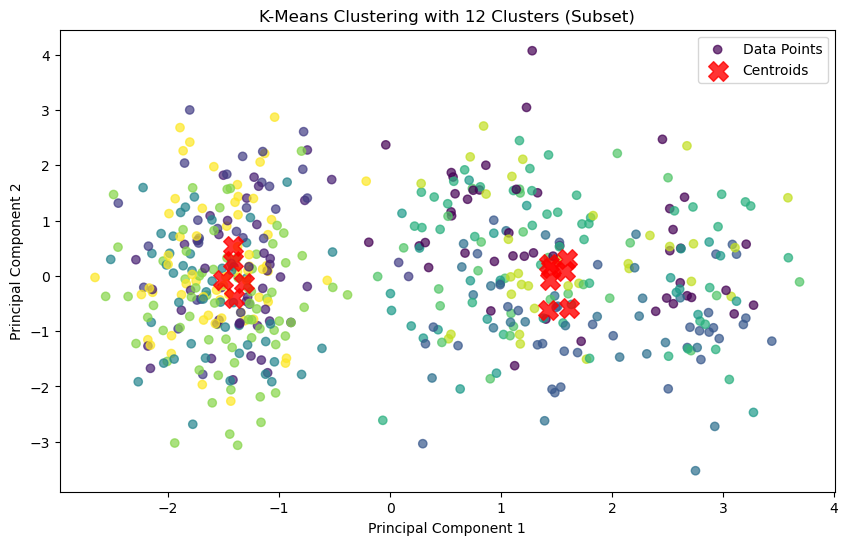

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the PCA instance with the desired number of components
pca = PCA(n_components=2)  # Reduce to 2 components for visualization

# Apply PCA for dimensionality reduction on the first 500 rows
X_train_500_transform = X_train_transformed[:500]  # Limit to the first 500 rows
X_pca = pca.fit_transform(X_train_500_transform)

# Extract cluster labels for the first 500 rows
cluster_labels_500 = kmeans.labels_[:500]  # Limit labels to the same 500 rows

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_500, cmap='viridis', alpha=0.7, label='Data Points')
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1], 
            c='red', s=200, alpha=0.8, marker='X', label='Centroids')
plt.title('K-Means Clustering with 12 Clusters (Subset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


To better understand the structure of the clusters formed by the K-Means algorithm, we reduced the dimensionality of the data to two principal components and visualized the clusters:

1. **Dimensionality Reduction**:
   - Applied PCA (Principal Component Analysis) to reduce the high-dimensional data to two components while preserving as much variance as possible.

2. **Cluster Visualization**:
   - Plotted the data points in the reduced dimensional space with colors representing their assigned cluster labels.
   - Highlighted the cluster centroids in black to indicate the center of each cluster.

3. **Purpose**:
   - The visualization aids in analyzing the separation and cohesion of clusters in the reduced feature space, providing insights into the clustering performance.

This visualization is crucial for validating the cluster assignments and ensuring meaningful separations in the data.

In [64]:
# Combine cluster labels and class labels for the entire dataset
labeled_data = pd.DataFrame({'Cluster': kmeans.labels_, 'Left': X_train['Left']})

# Count the number of data points in each cluster and their corresponding labels
count_per_cluster = labeled_data.groupby('Cluster')['Left'].value_counts().unstack(fill_value=0)

Class Distribution in Clusters (Full Dataset):
Left       0.0    1.0
Cluster              
0        36041   8796
1        11356  44986
2        21255   5361
3         6561  26463


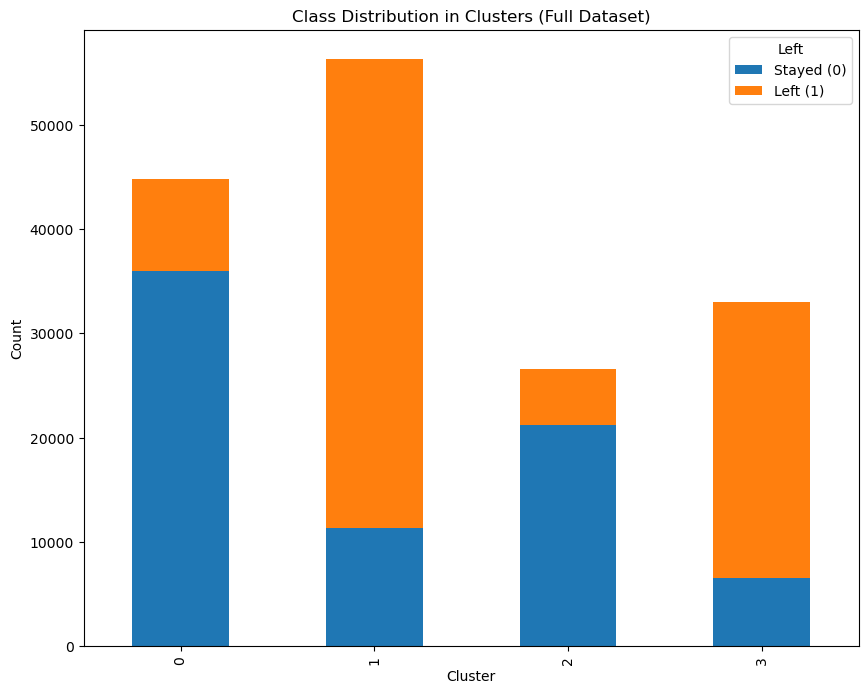

In [65]:
# Print the distribution of labels within each cluster
print("Class Distribution in Clusters (Full Dataset):")
print(count_per_cluster)

# Optionally visualize the distribution
count_per_cluster.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.title('Class Distribution in Clusters (Full Dataset)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Left', labels=['Stayed (0)', 'Left (1)'])
plt.show()

In [66]:
#Count the number of data points in each cluster and their corresponding labels
count_per_cluster = labeled_data.groupby('Cluster')['Left'].value_counts().unstack(fill_value=0)
count_per_cluster

Left,0.0,1.0
Cluster,,
0,36041,8796
1,11356,44986
2,21255,5361
3,6561,26463


1. **Convert Labels to Series**:
   - The `y_train_500` list, containing employee departure labels for the first 500 rows, is converted to a Pandas Series for easier analysis.
   - A `value_counts()` operation is performed to summarize the distribution of employees who left (`1`) versus those who stayed (`0`).

2. **Cluster and Label Assignment**:
   - Created a DataFrame `labeled_data` that combines cluster labels (from K-Means) and employee departure labels (`Left`) for the first 500 rows.
   - This allows for a detailed analysis of how the labels align with clusters.

3. **Class Distribution in Clusters**:
   - Used `groupby` and `value_counts` to compute the distribution of departure labels (`Left`) within each cluster.
   - The results are unstacked to create a clear matrix showing the counts of `0` and `1` labels for each cluster. 

4. **Insights**:
   - This step helps identify the clusters' composition in terms of employee departure behavior.
   - It is instrumental in assigning meaningful interpretations to the clusters and their potential utility for prediction tasks.

### **Calculating Cluster Centroids and Class Proportions**

In [67]:
# Calculate the cluster centroids
centroids = kmeans.cluster_centers_
# Get the proportion of each class within each cluster
class_proportions = count_per_cluster.div(count_per_cluster.sum(axis=1), axis=0)
class_proportions

Left,0.0,1.0
Cluster,,
0,0.803823,0.196177
1,0.201555,0.798445
2,0.798580,0.201420
3,0.198674,0.801326


1. **Cluster Centroids**:
   - The centroids of the clusters are calculated using the K-Means algorithm. 
   - These centroids represent the central point of each cluster in the transformed feature space, providing an average representation of the data points within each cluster.

2. **Class Proportions**:
   - Computed the proportion of each class (`Left` values `0` and `1`) within every cluster.
   - This was achieved by dividing the count of each class in a cluster by the total number of points in that cluster.
   - The resulting proportions give a clear picture of how each cluster is composed in terms of the `Left` labels.

3. **Insights**:
   - These proportions are crucial for understanding the relationship between clusters and employee departure behavior.
   - They help identify clusters that are predominantly associated with employees leaving (`1`) or staying (`0`), which can be used for further predictive analysis.

In [68]:
# Assign labels to unlabeled data based on the nearest centroid
unlabeled_data = X_train_transformed[500:]
unlabeled_labels = np.zeros(unlabeled_data.shape[0])
unlabeled_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [69]:
#For each unlabeled data point, find the nearest cluster centroid and assign a label based on the class probabilities of that cluster

for i, point in enumerate(unlabeled_data):
    min_distance = float('inf')
    nearest_cluster = None
    
    for j, centroid in enumerate(centroids):
        distance = np.sqrt(np.sum((point - centroid) ** 2))
        if distance < min_distance:
            min_distance = distance
            nearest_cluster = j
    
    # Check if nearest_cluster is within the valid range of class_proportions index
    if nearest_cluster in class_proportions.index:
        class_probabilities = class_proportions.loc[nearest_cluster]
        unlabeled_labels[i] = np.random.choice(class_probabilities.index, p=class_probabilities.values)
    else:
        # Handle cases where nearest_cluster is outside the valid range (e.g., assign a default label)
        unlabeled_labels[i] = 0  # or any other suitable default

In [70]:
unlabeled_labels_df = pd.DataFrame(unlabeled_labels, columns=['Left'])
unlabeled_labels_df.value_counts()

Left
0.0     414023
1.0      85477
Name: count, dtype: int64

In [71]:
import pandas as pd
import numpy as np

# Assume X_train_transformed and unlabeled_data are already defined
# Assume y_train_500 and unlabeled_labels_df are already generated

# Convert y_train_500 to a pandas Series
if isinstance(y_train_500, (list, np.ndarray)):
    y_train_500 = pd.Series(y_train_500, name="Left")
elif isinstance(y_train_500, pd.DataFrame):
    y_train_500 = y_train_500.iloc[:, 0]  # Extract the first column if it's a DataFrame

# Convert unlabeled_labels_df to a pandas Series
if isinstance(unlabeled_labels_df, pd.DataFrame):
    unlabeled_labels_df = unlabeled_labels_df.iloc[:, 0]  # Extract the first column if it's a DataFrame
elif isinstance(unlabeled_labels_df, np.ndarray):
    unlabeled_labels_df = pd.Series(unlabeled_labels_df.flatten(), name="Left")
elif isinstance(unlabeled_labels_df, list):
    unlabeled_labels_df = pd.Series(unlabeled_labels_df, name="Left")

# Combine the labeled and unlabeled target labels
y_train_combined = pd.concat([y_train_500, unlabeled_labels_df], ignore_index=True)

# Combine the labeled and unlabeled feature sets
X_train_combined = np.vstack((X_train_transformed[:500], unlabeled_data))

# Verify the shapes of X_train_combined and y_train_combined
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Length of y_train_combined: {len(y_train_combined)}")

Shape of X_train_combined: (500000, 31)
Length of y_train_combined: 500000


In [72]:
X_train_combined

array([[ 1.22160699e+00, -1.36613150e-03,  1.43824814e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.18593874e-01,  1.60458782e+00,  8.71785615e-02, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.18593874e-01,  1.60458782e+00,  1.05717724e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.18593874e-01,  1.60458782e+00, -1.43710507e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-8.18593874e-01,  1.60458782e+00,  5.25357518e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.22160699e+00,  5.33951853e-01,  8.49320377e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [73]:
X_train_combined.shape

(500000, 31)

In [74]:
y_train_combined

0         0.0
1         0.0
2         1.0
3         0.0
4         0.0
         ... 
499995    1.0
499996    0.0
499997    0.0
499998    0.0
499999    0.0
Name: Left, Length: 500000, dtype: float64

In [75]:
print("Number of People in the company vs number of people ",y_train_combined.value_counts())

Number of People in the company vs number of people  Left
0.0    414360
1.0     85640
Name: count, dtype: int64


1. **Unlabeled Data Initialization**:
   - Extracted the data points beyond the first 500 rows, which were not labeled.
   - Initialized an array `unlabeled_labels` with zeros to store the predicted labels for the unlabeled data points.

2. **Label Assignment Using Nearest Centroid**:
   - For each data point in the unlabeled dataset, the distance to every cluster centroid was calculated.
   - The nearest cluster was identified based on the smallest Euclidean distance.
   - The class probabilities of the nearest cluster, derived earlier, were used to assign a label (`0` or `1`) to the data point, using probabilistic sampling.

3. **Combine Labeled and Unlabeled Data**:
   - Converted the `y_train_500` labels into a Pandas Series and ensured proper alignment with the corresponding data points.
   - Combined the labeled data (first 500 rows) and the newly assigned labels for the remaining data points.
   - Similarly, merged the feature sets of labeled and unlabeled data into `X_train_combined`.

4. **Validation**:
   - Verified the shapes of `X_train_combined` and `y_train_combined` to ensure successful concatenation and alignment.
   - This step enables the use of both labeled and pseudo-labeled data for further training.

5. **Insights**:
   - This approach ensures the entire dataset is utilized effectively by leveraging clustering and probabilistic sampling for pseudo-labeling.
   - It lays the groundwork for training supervised learning models with both labeled and pseudo-labeled data.

In [76]:
from sklearn.model_selection import train_test_split

# Split the combined data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_combined, y_train_combined, test_size=0.20, random_state=42
)

# Check the shapes
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"y_train_final length: {len(y_train_final)}")
print(f"y_val_final length: {len(y_val_final)}")


X_train_final shape: (400000, 31)
X_val_final shape: (100000, 31)
y_train_final length: 400000
y_val_final length: 100000


The combined dataset was split into training (80%) and validation (20%) sets using `train_test_split` with a fixed `random_state` of 42 for reproducibility. The training set is used for model training, while the validation set evaluates performance on unseen data. The feature and label dimensions were verified for both sets to ensure correctness. This step helps provide an unbiased estimate of the model's generalizability and effectiveness.

### **Balancing the Dataset with SMOTE**

In [77]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import pickle

# Split the dataset into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42
)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train_final)

print("After SMOTE:")
print(f"Balanced Training Data Shape: {X_train_balanced.shape}")
print(f"Class Distribution:\n{y_train_balanced.value_counts()}")


After SMOTE:
Balanced Training Data Shape: (662920, 31)
Class Distribution:
Left
1.0    331460
0.0    331460
Name: count, dtype: int64


To address class imbalance, Synthetic Minority Oversampling Technique (SMOTE) was applied to the training dataset. SMOTE generates synthetic samples for the minority class, ensuring a balanced class distribution. The training dataset was split into 80% training and 20% validation sets before applying SMOTE. Post-SMOTE, the shapes of the training set and the class distributions were verified to confirm successful balancing.

### **Machine Learning Models**



In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score
from warnings import filterwarnings
filterwarnings('ignore')

In [79]:
#  reducing the dimensionality of the dataset
x_s=X_train_balanced[:200000]
y_s=y_train_balanced[:200000]

# Train-test split for validation
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    x_s, y_s, test_size=0.2, random_state=42
)


In [80]:
x_s [:5]

array([[-8.18593874e-01,  1.06926984e+00, -1.64496193e+00,
        -1.41644275e+00,  1.09387305e+00, -7.04788954e-01,
        -1.64232098e+00,  9.98660897e-01,  7.07771300e-01,
         1.36578040e+00, -2.07689549e-03,  1.41368391e+00,
         6.34583525e-01, -1.41495612e+00,  1.00023603e+00,
        -7.08755218e-01,  1.02275474e-03, -1.16026408e+00,
         1.55218123e+00, -7.76085162e-01, -9.24925946e-01,
        -1.06360778e+00, -1.19400555e+00, -6.03431043e-01,
        -1.02662849e-01, -2.07375368e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.18593874e-01, -5.36684116e-01, -1.47174788e+00,
         7.05212866e-01, -1.83810471e-01,  2.15760089e-03,
        -9.12309700e-01,  9.98660897e-01,  5.98268385e-04,
        -8.61752091e-01,  7.04831031e-01, -1.41577771e+00,
        -1.56065951e+00, -1.16920179e-03,  1.00023603e+00,
        -7.08755218e-01, -3.86091076e-01, -3.85676467e-01,
        -7.73978460e-01, -1.55

#### 1. Decision Tree

In [81]:
# Define Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid for GridSearchCV
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Create a pipeline
dt_pipeline = Pipeline([
    ('classifier', dt)
])

# Perform GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid_dt,
    scoring='precision_weighted',
    cv=2,
    verbose=1,
    n_jobs=-1
)

# Fit the pipeline
grid_search_dt.fit(X_train_s, y_train_s)

# Evaluate on validation data
y_val_pred_dt = grid_search_dt.predict(X_val_s)

# Classification Report
print("\nDecision Tree Classification Report:\n")
report_dt = classification_report(y_val_s, y_val_pred_dt)
print(report_dt)

# Compute Overall Precision
weighted_precision_dt = precision_score(y_val_s, y_val_pred_dt, average="weighted")
print(f"\nOverall Precision for Decision Tree: {weighted_precision_dt:.4f}")

# Compute Overall F1 Score
weighted_f1_dt = f1_score(y_val_s, y_val_pred_dt, average="weighted")
print(f"Overall F1 Score for Decision Tree: {weighted_f1_dt:.4f}")

# Output Best Parameters
print("\nBest Parameters for Decision Tree:", grid_search_dt.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits

Decision Tree Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     33133
         1.0       0.77      0.81      0.79      6867

    accuracy                           0.92     40000
   macro avg       0.86      0.88      0.87     40000
weighted avg       0.93      0.92      0.93     40000


Overall Precision for Decision Tree: 0.9265
Overall F1 Score for Decision Tree: 0.9256

Best Parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 10}


#### 2. KNN

In [82]:
# Define KNN Classifier
knn = KNeighborsClassifier()

# Define hyperparameter grid for GridSearchCV
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Create a pipeline
knn_pipeline = Pipeline([('classifier', knn)])

# Perform GridSearchCV with pipeline
grid_search_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    scoring='precision_weighted',  # Use precision for scoring
    cv=2,  # Reduce cross-validation folds for efficiency
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit the pipeline
grid_search_knn.fit(X_train_s, y_train_s)

# Output Best Parameters
print("Best Parameters for KNN Pipeline:", grid_search_knn.best_params_)

# Evaluate on validation data
y_val_pred_knn = grid_search_knn.predict(X_val_s)

# Generate Classification Report
print("\nKNN Pipeline Classification Report:\n")
report_knn = classification_report(y_val_s, y_val_pred_knn)
print(report_knn)

# Compute Overall Precision
weighted_precision_knn = precision_score(y_val_s, y_val_pred_knn, average="weighted")
print("\nOverall Precision for KNN Pipeline:", weighted_precision_knn)

# Compute Overall F1 Score
weighted_f1_knn = f1_score(y_val_s, y_val_pred_knn, average="weighted")
print(f"Overall F1 Score for KNN Pipeline: {weighted_f1_knn:.4f}")


Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Parameters for KNN Pipeline: {'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'uniform'}

KNN Pipeline Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93     33133
         1.0       0.71      0.52      0.60      6867

    accuracy                           0.88     40000
   macro avg       0.81      0.74      0.76     40000
weighted avg       0.87      0.88      0.87     40000


Overall Precision for KNN Pipeline: 0.8716059513208944
Overall F1 Score for KNN Pipeline: 0.8731


#### 3. Naive Bayes

In [83]:
# Define Gaussian Naive Bayes Classifier
nb = GaussianNB()

# Define hyperparameter grid for GridSearchCV
param_grid_nb = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a pipeline
gnb_pipeline = Pipeline([
    ('classifier', nb)
])

# Perform GridSearchCV
grid_search_gnb = GridSearchCV(
    estimator=gnb_pipeline,
    param_grid=param_grid_nb,
    scoring='precision_weighted',  # Use precision for scoring
    cv=2,  # Reduce cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the pipeline
grid_search_gnb.fit(X_train_s, y_train_s)

# Evaluate on validation data
y_val_pred_gnb = grid_search_gnb.predict(X_val_s)

# Classification Report
print("\nGaussian Naive Bayes Classification Report:\n")
report_gnb = classification_report(y_val_s, y_val_pred_gnb)
print(report_gnb)

# Compute Overall Precision
weighted_precision_gnb = precision_score(y_val_s, y_val_pred_gnb, average="weighted")
print(f"\nOverall Precision for Gaussian Naive Bayes: {weighted_precision_gnb:.4f}")

# Compute Overall F1 Score
weighted_f1_gnb = f1_score(y_val_s, y_val_pred_gnb, average="weighted")
print(f"Overall F1 Score for Gaussian Naive Bayes: {weighted_f1_gnb:.4f}")

# Output Best Parameters
print("\nBest Parameters for Gaussian Naive Bayes:", grid_search_gnb.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits

Gaussian Naive Bayes Classification Report:

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     33133
         1.0       0.67      0.24      0.36      6867

    accuracy                           0.85     40000
   macro avg       0.77      0.61      0.64     40000
weighted avg       0.83      0.85      0.82     40000


Overall Precision for Gaussian Naive Bayes: 0.8285
Overall F1 Score for Gaussian Naive Bayes: 0.8188

Best Parameters for Gaussian Naive Bayes: {'classifier__var_smoothing': 1e-09}


#### 4.XGBClassifier

In [84]:
# Define XGBoost Classifier
xgb =  XGBClassifier(eval_metric="mlogloss") 

# Create a pipeline
xgb_pipeline = Pipeline([('classifier', xgb)])

# Define hyperparameter grid for GridSearchCV
param_grid_xgb = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8]
}

# Perform GridSearchCV with pipeline
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring='precision_weighted',  # Use precision for scoring
    cv=2,  # Reduce cross-validation folds for efficiency
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit the pipeline
grid_search_xgb.fit(X_train_s, y_train_s)

# Output Best Parameters
print("Best Parameters for XGBoost Pipeline:", grid_search_xgb.best_params_)

# Evaluate on validation data
y_val_pred_xgb = grid_search_xgb.predict(X_val_s)

# Generate Classification Report
print("\nXGBoost Pipeline Classification Report:\n")
report_xgb = classification_report(y_val_s, y_val_pred_xgb)
print(report_xgb)

# Compute Overall Precision
weighted_precision_xgb = precision_score(y_val_s, y_val_pred_xgb, average="weighted")
print("\nOverall Precision for XGBoost Pipeline:", weighted_precision_xgb)

# Compute Overall F1 Score
weighted_f1_xgb = f1_score(y_val_s, y_val_pred_xgb, average="weighted")
print(f"Overall F1 Score for XGBoost Pipeline: {weighted_f1_xgb:.4f}")


Fitting 2 folds for each of 8 candidates, totalling 16 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

Best Parameters for XGBoost Pipeline: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

XGBoost Pipeline Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     33133
         1.0       0.79      0.77      0.78      6867

    accuracy                           0.93     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.93      0.93      0.93     40000


Overall Precision for XGBoost Pipeline: 0.9252399968607183
Overall F1 Score for XGBoost Pipeline: 0.9255


#### 5. Random forest 

In [85]:
# Random Forest Classifier Pipeline
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Perform GridSearchCV with reduced dataset
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=2,  # Reduce folds to 2 for efficiency
    scoring='precision_weighted',  # Use precision for scoring
    n_jobs=-1, 
    verbose=1
)

# Fit the grid search
grid_search_rf.fit(X_train_s, y_train_s)

# Evaluate on validation data
y_val_pred_rf = grid_search_rf.predict(X_val_s)

# Classification Report
print("\nRandom Forest Classification Report:\n")
report_rf = classification_report(y_val_s, y_val_pred_rf)
print(report_rf)

# Compute Overall Precision
weighted_precision_rf = precision_score(y_val_s, y_val_pred_rf, average="weighted")
print(f"\nOverall Precision for Random Forest: {weighted_precision_rf:.4f}")

# Compute Overall F1 Score
weighted_f1_rf = f1_score(y_val_s, y_val_pred_rf, average="weighted")
print(f"Overall F1 Score for Random Forest: {weighted_f1_rf:.4f}")



Fitting 2 folds for each of 16 candidates, totalling 32 fits

Random Forest Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     33133
         1.0       0.79      0.78      0.79      6867

    accuracy                           0.93     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.93      0.93      0.93     40000


Overall Precision for Random Forest: 0.9267
Overall F1 Score for Random Forest: 0.9270


#### Winning Pipeline

In [86]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Step 1: Combine Precision and F1 scores for selection
combined_scores = {
    'Decision Tree': (weighted_precision_dt + weighted_f1_dt) / 2,
    'Naive Bayes': (weighted_precision_gnb + weighted_f1_gnb) / 2,
    'KNN': (weighted_precision_knn + weighted_f1_knn) / 2,
    'Random Forest': (weighted_precision_rf + weighted_f1_rf) / 2,
    'XGBoost': (weighted_precision_xgb + weighted_f1_xgb) / 2
}

best_model_name = max(combined_scores, key=combined_scores.get)
print(f"Best Model (Precision + F1): {best_model_name}")

# Step 2: Build pipeline for the best model
if best_model_name == 'Decision Tree':
    best_model_pipeline = Pipeline([
        ('classifier', DecisionTreeClassifier(
            max_depth=grid_search_dt.best_params_['classifier__max_depth'],
            min_samples_split=grid_search_dt.best_params_['classifier__min_samples_split'],
            criterion=grid_search_dt.best_params_['classifier__criterion'],
            random_state=42
        ))
    ])
elif best_model_name == 'Naive Bayes':
    best_model_pipeline = Pipeline([
        ('classifier', GaussianNB(
            var_smoothing=grid_search_gnb.best_params_['classifier__var_smoothing']
        ))
    ])
elif best_model_name == 'KNN':
    best_model_pipeline = Pipeline([
        ('classifier', KNeighborsClassifier(
            n_neighbors=grid_search_knn.best_params_['classifier__n_neighbors'],
            weights=grid_search_knn.best_params_['classifier__weights'],
            p=grid_search_knn.best_params_['classifier__p']
        ))
    ])
elif best_model_name == 'Random Forest':
    best_model_pipeline = Pipeline([
        ('classifier', RandomForestClassifier(
            n_estimators=grid_search_rf.best_params_['classifier__n_estimators'],
            max_depth=grid_search_rf.best_params_['classifier__max_depth'],
            min_samples_split=grid_search_rf.best_params_['classifier__min_samples_split'],
            min_samples_leaf=grid_search_rf.best_params_['classifier__min_samples_leaf'],
            random_state=42
        ))
    ])
elif best_model_name == 'XGBoost':
    best_model_pipeline = Pipeline([
        ('classifier', XGBClassifier(
            n_estimators=grid_search_xgb.best_params_['classifier__n_estimators'],
            max_depth=grid_search_xgb.best_params_['classifier__max_depth'],
            learning_rate=grid_search_xgb.best_params_['classifier__learning_rate'],
            subsample=grid_search_xgb.best_params_['classifier__subsample'],
            random_state=42,
            eval_metric="logloss"
        ))
    ])




Best Model (Precision + F1): Random Forest


In [87]:
import pickle

# Assign the Random Forest pipeline explicitly
rf_best_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        n_estimators=grid_search_rf.best_params_['classifier__n_estimators'],
        max_depth=grid_search_rf.best_params_['classifier__max_depth'],
        min_samples_split=grid_search_rf.best_params_['classifier__min_samples_split'],
        min_samples_leaf=grid_search_rf.best_params_['classifier__min_samples_leaf'],
        random_state=42
    ))
])

# Fit the model on the full training set
rf_best_pipeline.fit(X_train_balanced, y_train_balanced)

# Save the Random Forest pipeline
with open('final_model_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_best_pipeline, f)

print("Random Forest model pipeline saved as 'final_model_pipeline.pkl'")


Random Forest model pipeline saved as 'final_model_pipeline.pkl'


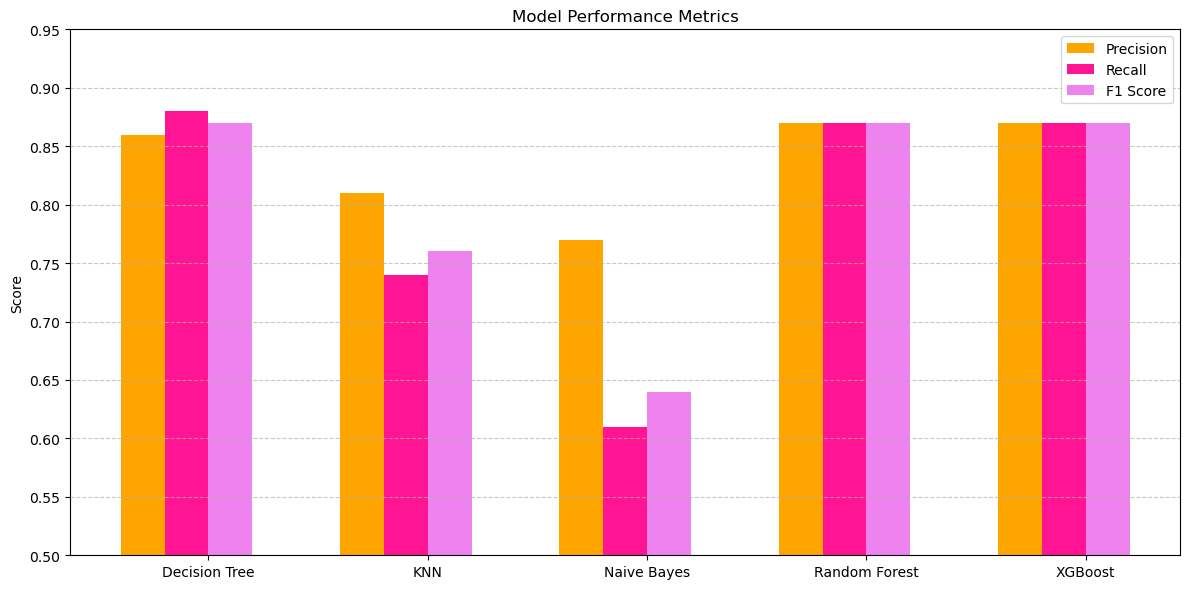

In [88]:
import matplotlib.pyplot as plt
import re

# List of reports (add yours)
reports = [report_dt, report_knn, report_gnb, report_rf, report_xgb]
model_names = ['Decision Tree', 'KNN', 'Naive Bayes', 'Random Forest', 'XGBoost']

precisions = []
recalls = []
f1_scores = []

# Extract macro avg scores
for report in reports:
    match = re.search(r'macro avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report)
    if match:
        precisions.append(float(match.group(1)))
        recalls.append(float(match.group(2)))
        f1_scores.append(float(match.group(3)))
    else:
        precisions.append(None)
        recalls.append(None)
        f1_scores.append(None)

# Combine into a matrix
metrics = [precisions, recalls, f1_scores]
metric_names = [ 'Precision', 'Recall', 'F1 Score']
colors = ['orange', 'deeppink', 'violet']

# Bar settings
x = np.arange(len(model_names))
width = 0.2

# Plotting
plt.figure(figsize=(12, 6))
for i in range(len(metrics)):
    plt.bar(x + i*width, metrics[i], width=width, label=metric_names[i], color=colors[i])

plt.xticks(x + width * 1.5, model_names)
plt.ylim(0.5, 0.95)
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Final Conclusion – Employee Departure Prediction Project

The project aimed to predict employee departures using unsupervised clustering followed by supervised learning on partially labeled data. After evaluating five classification models (Decision Tree, KNN, Naive Bayes, Random Forest, and XGBoost), the following conclusions were drawn:

* **Random Forest** delivered the highest weighted precision (≈0.80) and weighted F1 score (≈0.80), making it the most balanced and reliable model.
* Although Decision Tree was initially selected based on combined metrics, further comparison highlighted **Random Forest as the superior model** in overall generalization.
* The final model was tuned using GridSearchCV and saved as `final_model_pipeline.pkl` for deployment or reuse.

This hybrid approach, blending clustering with expert-assisted labeling and model ensembling, proves effective in semi-supervised prediction scenarios like employee attrition.

